In [1]:
%matplotlib inline

from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from itertools import combinations
import time as trun
import igraph as ig

import gurobipy as gp
from gurobipy import GRB

In [2]:
def is_subclique(G, nodelist):
    '''
    For each pair of nodes in nodelist whether there is an edge
    if any edge is missing, we know that it's not a subclique.
    if all edges are there, it is a subclique
    '''
    for (u,v) in combinations(nodelist,2):  #check each possible pair
        if not G.has_edge(u,v):
            return False #if any edge is missing we're done
    return True  #if we get to here, then every edge was there.  It's True.


In [7]:
#instance

#inst_="internet_graph"
#dim_=75
#id_=1
#instance_=f"{inst_}_{dim_}_{id_}"
#G = nx.read_gml(f"../instances/{inst_}/{dim_}/{instance_}.gml.gz",destringizer=int)

inst_="karate"
instance_=f"{inst_}"
G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

#inst_="dodecahedral"
#instance_=f"{inst_}"
#G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

#inst_="cube"
#instance_=f"{inst_}"
#G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

#inst_="circut_example"
#instance_=f"{inst_}"
#G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

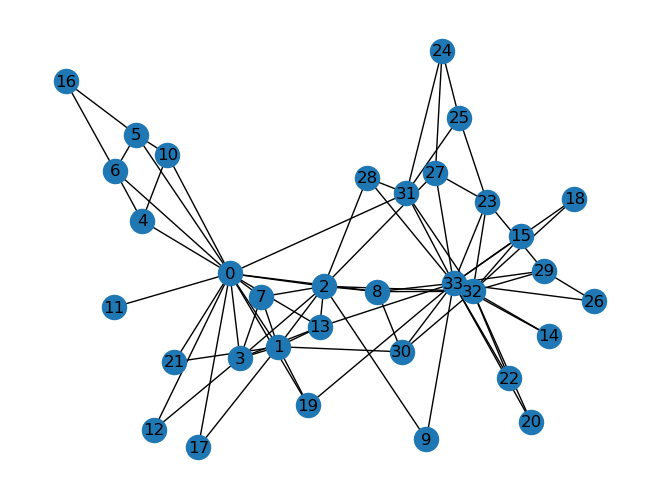

In [8]:
nx.draw(G,  with_labels = True)

In [9]:
nx.is_connected(G)

True

In [10]:
nx.diameter(G)

5

In [11]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1
        #print("dist %d %d = %d" %(i, j, dm[i,j]))

In [15]:
form_="fmin"
method_="lp"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

con_geo_c1 = 0
con_geo_c2 = 0
con_miset = 0
con_miset_c3 = 1
con_concav = 0

for i in G:

    print("node")
    print(i)

    if i>0:
        continue

    Ni = nx.neighbors(G,i)

    listNi = []
    for k in Ni:
        listNi.append(k)

    tstart = trun.time()
    status_clique = is_subclique(G, listNi)
    tend = trun.time()

    elapsed_time = tend - tstart
    
    if(status_clique):
        #print("tukey[%d] = 1" %i)
        lb[i] = 1
        ub[i] = 1
        gap[i] = 0.0
        time[i] = elapsed_time
        nodes[i] = 0
        status[i] = 1

    else:

        val_x = np.zeros((N), dtype=float)

        model = gp.Model(f"{instance_}")

        if (method_=="mip"):
            x = model.addVars(N, vtype=GRB.BINARY, name="x")
        else:
            x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
        obj = 0
        for j in G:
            obj += 1 * x[j]
         
        model.setObjective(obj, GRB.MINIMIZE)
    
        # configurando parametros
        # model.Params.TimeLimit = 60
        model.Params.MIPGap = 1.e-6
        model.Params.Threads = 1
        # model.Params.Presolve = 0
        # model.Params.Cuts = 0
 
        # Turn off display and heuristics
        gp.setParam('OutputFlag', 0)
        gp.setParam('Heuristics', 0)

        model.addConstr(x[i] == 1, "fix_x")

        # geodesic
        if con_geo_c1 == 1:
            for u in range(0,N):
                for w in range(u+1,N):
                    #if dm[u,w] <= N:
                    for s in range(0,N):
                        if (s != u) and (s != w):
                            if (dm[u,s] + dm[s,w] == dm[u,w]):
                                model.addConstr(x[u] + x[w] >= x[s], "geo_c1")

        # geodesic neighbors
        if con_geo_c2 == 1:
            for u in range(0,N):
                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)

                for w in range(0,N):
                    if (w != u) and (w not in listNu):
                        for s in listNu:
                            if (s != w) and (dm[u,s] + dm[s,w] == dm[u,w]):
                                model.addConstr(x[u] + x[w] >= x[s], "geo_c2")


        if con_miset == 1:
            # maximal independent set
            for u in range(0,N):

                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)
                
                count = 0
                dicl = {}
                for it in listNu:
                    dicl[count] = it
                    count += 1

                T = nx.Graph()
                T.add_nodes_from(listNu)

                for (a,b) in combinations(listNu,2):
                    if G.has_edge(a,b):
                        T.add_edge(a,b)

                #nx.draw(T,  with_labels = True)

                A = ig.Graph.from_networkx(T)
                #Im = nx.maximal_independent_set(T)
                Im = A.maximal_independent_vertex_sets()
                
                #print("Im")
                #print(Im)                

                tmp = len(Im)
                if (tmp > 0):
                    #print("dim Im: %d" %(tmp))
                    for itIm in Im:
                        #print(itIm)
                        constr = 0
                        for j in itIm:
                            #print(dicl[j])
                            constr += 1 * x[dicl[j]]
                        model.addConstr(constr >= (len(itIm) - 1)*x[u], "miset")

                T.clear()
                listNu.clear()

        if con_miset_c3 == 1:
            # maximal independent set
            for u in range(0,N):

                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)

                count = 0
                dicl = {}
                for it in listNu:
                    dicl[count] = it
                    count += 1

                T = nx.Graph()
                T.add_nodes_from(listNu)
                for (a,b) in combinations(listNu,2):
                    if G.has_edge(a,b):
                        T.add_edge(a,b)

                #nx.draw(T,  with_labels = True)

                A = ig.Graph.from_networkx(T)
                #Im = nx.maximal_independent_set(T)
                Im = A.maximal_independent_vertex_sets()

                tmp = len(Im)
                if (tmp > 0):
                    #print("dim Im: %d" %(tmp))
                    for itIm in Im:
                        #print(itIm)
                        constr = 0
                        for j in itIm:
                            #print(dicl[j])
                            constr += 1 * x[dicl[j]]
                        model.addConstr(constr >= (len(itIm) - 1)*x[u], "miset_c3")

                for w in range(u+1,N):
                    if (dm[u,w] >= 3):
                        if (w != u) and (w not in listNu):
                            for s in listNu:
                                if (s != w) and (dm[u,s] + dm[s,w] == dm[u,w]):
                                    #print("dm %d %d : %d" %( u, w, dm[u,w]))
                                    model.addConstr(x[u] + x[w] >= x[s], "geo_c3")

                T.clear()
                listNu.clear()
        
        # concav constraint
        if con_concav == 1:
            for u in range(0,N):
                for w in range(u+1,N):
                    if (ub[u] > 0) and (ub[w] > 0):
                        constr = 0
                        for j in range(0,N):
                            constr += 1 * x[j]
                        model.addConstr(constr >= min(ub[u],ub[w]), "concav")

        model.write(f"{instance_}_{i}_v2.lp")

        model.optimize()

        val_x = [x[j].X for j in range(0,N)]

        for j in range(0,N):
            print(val_x[j])

        tmp = 0
        if model.status == GRB.OPTIMAL:
            tmp = 1
    
        if (method_=="mip"):
            lb[i] = model.objBound
            ub[i] = model.objVal
            gap[i] = model.MIPGap
            time[i] = model.Runtime
            nodes[i] = model.NodeCount
            status[i] = tmp
        else:
            ub[i] = model.objVal
            time[i] = model.Runtime
            status[i] = tmp

        model.dispose()

node
0
1.0
0.8840694006309149
0.40063091482649843
0.6522082018927442
1.0
1.0
0.9999999999999998
1.0
0.6522082018927445
0.1151419558359621
1.0
1.0
1.0
0.6522082018927444
0.0
0.0
1.0
1.0
0.0
0.8840694006309149
0.0
1.0
0.0
0.0
0.5993690851735016
0.5993690851735016
0.251577287066246
0.0
0.6522082018927444
0.21214511041009454
0.2515772870662461
0.8115141955835962
0.18296529968454234
0.25157728706624605
node
1
node
2
node
3
node
4
node
5
node
6
node
7
node
8
node
9
node
10
node
11
node
12
node
13
node
14
node
15
node
16
node
17
node
18
node
19
node
20
node
21
node
22
node
23
node
24
node
25
node
26
node
27
node
28
node
29
node
30
node
31
node
32
node
33


In [10]:
tksum = np.sum(ub)
tkmax = np.max(ub)
tktime = np.sum(time)

In [11]:
if method_ == "lp":
    for i in G:
        print("vertice:%d, ub: %.2f, time: %.2f " % (i, ub[i], time[i]))

    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))

if method_ == "mip":
    for i in G:
        print(
            "vertice:%d, lb: %d, ub: %d, gap: %.2f, time: %.2f, nodes: %d, status: %d " 
            % (i, lb[i], ub[i], gap[i], time[i], nodes[i], status[i])
            )

    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))

G.clear()

vertice:0, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:1, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:2, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:3, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:4, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:5, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
tksum : 12.00
tkmax : 2.00
tktime : 0.00
